# Deep Learning - Lab 3
# Neural Network Basics

**Name: Faizaan Al Faisal**

__________________________________________


Most machine learning workflows involve working with data, creating models, optimizing model parameters, and saving the trained models. This tutorial introduces you to a complete ML workflow implemented in PyTorch covering all these steps.

#Task 1

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import random
import numpy as np

Check if GPU is available.

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print ('<== CUDA availability : ==>', use_cuda)

<== CUDA availability : ==> True


Set seed for reproducability.

In [ ]:
def set_seeds(seed):
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.determinictic = True
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
set_seeds(42)

PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this lab, we will be using a TorchVision dataset. Load one of the prebuilt datasets from pytorch repository. Currently, we are not using any transform (manipulation) on input data. We are just converting each image to tensor.


In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Visualise some of the input images.

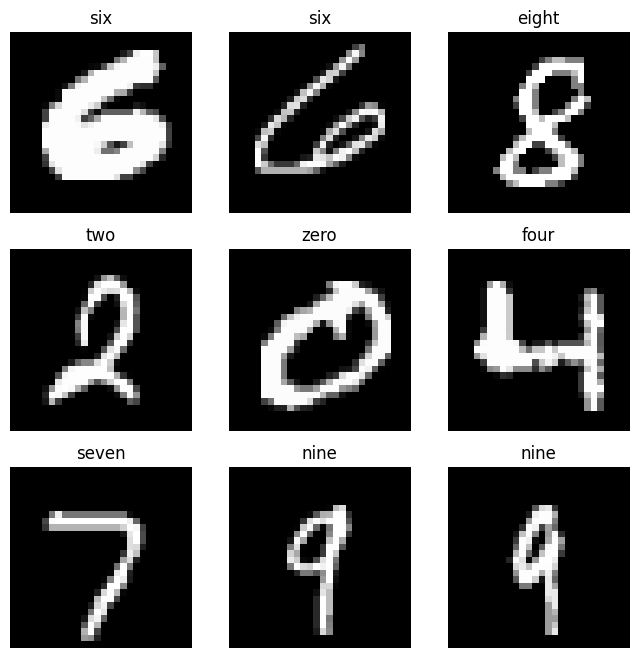

In [ ]:
labels_map = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()  # randomly pick indices from the training data
    img, label = training_data[sample_idx]                            # Read the images using their indices.
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Check the size and shape of training and validation data.

In [ ]:
print ('Shape of Training Data', np.shape(training_data))
print ('Shape of Test Data', np.shape(test_data))

Shape of Training Data (60000, 2)
Shape of Test Data (10000, 2)


The shape of the training set is (6000,2). This means that we have 6000 thousand samples with 2 entities. The first entity is the image and the second entity is its label. Forexample:

**training_data[0][0]** is the first image of training set

**training_data[0][1]** is the label of the first image in the training set

Now pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
          nn.Linear(28*28, 512),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)


# Q1 You may change the width of each layer from 128 to 256 and 512 and observe the difference in network performance.

# Try adding and removing layers. Keeping all other setup the same, how does the network behave with the change in depth (number of layers) and width (size of each layer)?

Now define the loss function and set up optimiser.

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4 )

# Q2: Try changing the learning rate from 1e-3 to 1e-4. What do you observe?

# Try the Adam optimizer instead of SGD. How the learning process changes?



Define train function.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

Define evaluation function.

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Initiate Training Process

Epoch 1
-------------------------------
test loss: 
Accuracy: 91.2%, avg loss: 0.315276 

Epoch 2
-------------------------------
test loss: 
Accuracy: 92.9%, avg loss: 0.234188 

Epoch 3
-------------------------------
test loss: 
Accuracy: 94.2%, avg loss: 0.191599 

Epoch 4
-------------------------------
test loss: 
Accuracy: 95.2%, avg loss: 0.159453 

Epoch 5
-------------------------------
test loss: 
Accuracy: 95.9%, avg loss: 0.138229 

Epoch 6
-------------------------------
test loss: 
Accuracy: 96.3%, avg loss: 0.121708 

Epoch 7
-------------------------------
test loss: 
Accuracy: 96.6%, avg loss: 0.110100 

Epoch 8
-------------------------------
test loss: 
Accuracy: 96.9%, avg loss: 0.100419 

Epoch 9
-------------------------------
test loss: 
Accuracy: 97.1%, avg loss: 0.093811 

Epoch 10
-------------------------------
test loss: 
Accuracy: 97.4%, avg loss: 0.088320 

Epoch 11
-------------------------------
test loss: 
Accuracy: 97.4%, avg loss: 0.083874 

Epoch 12

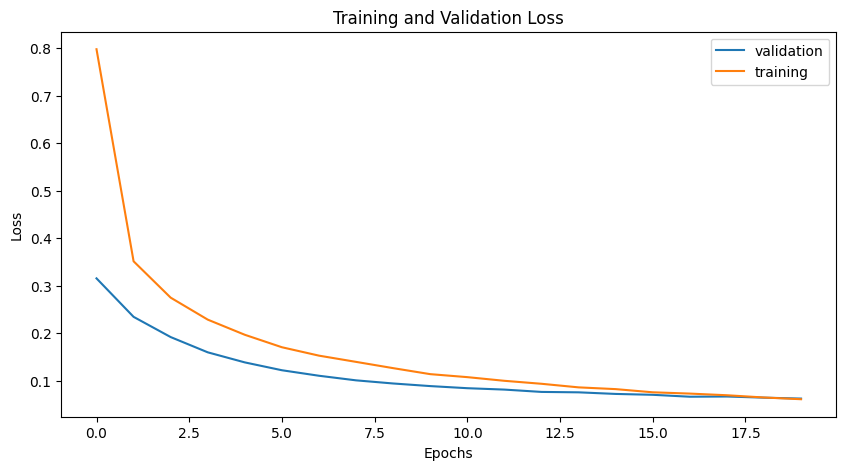

In [ ]:
epochs = 20
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Q3: Try 5, 10 and 50 epoch and record values for average validation loss and accuracy

# Q4: What activation function is generally used for multiclass classification? Why didn't we use an activation function at the end of our neural network that we have defined?



In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Perform Inferrence

Predicted: "two", Actual: "two"


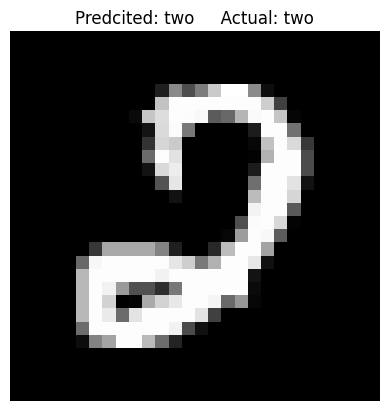

In [ ]:
classes = [
    "zero",
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine",
]
#classes = np.array(test_data.class_to_idx.values())
#testimg = random.
model.eval()
sample_number = 400 # Keep 0 <= sample_number < 10,000
x, y = test_data[sample_number][0], test_data[sample_number][1]
model.to("cpu")
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

img, label = test_data[sample_number]                            # Read the images using their indices.
    #figure.add_subplot(rows, cols, i)
plt.figure()
plt.title("Predcited: "+ predicted + "     Actual: " + labels_map[label])
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")

#Task 2

#Repeat all of above steps for Fashion MNIST dataset, apply question 1, 2 and 3 and report the accuracies.

In [280]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [281]:
# data loading and handling
batch_size = 32
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [282]:
# neural network classifier for fashion mnist data
class FashionMNISTClassifier(nn.Module):
    def __init__(self):
        super(FashionMNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential( # setting the layers
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [283]:
# model, loss function, and optimizer
model = FashionMNISTClassifier()
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Epoch 1
--------------------------------------------------------------
Training Loss: 0.8801, Validation Loss: 0.8480, Accuracy: 0.7971


Epoch 2
--------------------------------------------------------------
Training Loss: 0.5768, Validation Loss: 0.6731, Accuracy: 0.8236


Epoch 3
--------------------------------------------------------------
Training Loss: 0.5107, Validation Loss: 0.5545, Accuracy: 0.8319


Epoch 4
--------------------------------------------------------------
Training Loss: 0.4770, Validation Loss: 0.4579, Accuracy: 0.8421


Epoch 5
--------------------------------------------------------------
Training Loss: 0.4559, Validation Loss: 0.5230, Accuracy: 0.8433


Epoch 6
--------------------------------------------------------------
Training Loss: 0.4406, Validation Loss: 0.5995, Accuracy: 0.8548


Epoch 7
--------------------------------------------------------------
Training Loss: 0.4230, Validation Loss: 0.3774, Accuracy: 0.8537


Epoch 8
--------------------------

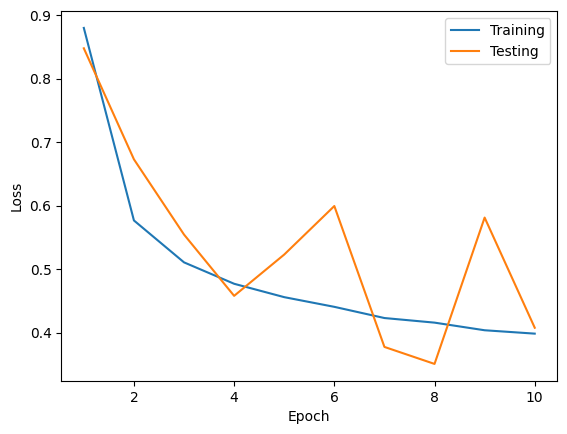

In [284]:
# Lists to store losses for plotting
train_losses = []
test_losses = []

epochs = 10
for epoch in range(epochs):

  # training phase
  model.train()
  running_loss = 0.0

  for inputs, labels in train_loader:
    # calculate initial predicted outputs
    optimizer.zero_grad()
    outputs = model(inputs)
    # calculate loss using cross-entropy loss
    loss = ce_loss(outputs, labels)
    # backward propagation
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  train_loss = running_loss / len(train_loader)
  train_losses.append(train_loss)


  # evaluation or testing phase
  model.eval()
  total = 0
  correct = 0
  running_test_loss = 0.0

  with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  test_loss = running_test_loss / len(test_loader)
  test_losses.append(test_loss)
  # accuracy and display
  acc = correct / total
  print(f"Epoch {epoch+1}\n--------------------------------------------------------------")
  print(f"Training Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}, Accuracy: {acc:.4f}\n\n")


# plotting
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), train_losses, label='Training')
plt.plot(range(1, epochs + 1), test_losses, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


#**Submission**

## **Submit a lab report containing codes, screenshots of output and tables for comparision of accuracies for both task 1 and task2 (for both MNIST and Fashion MNIST datasets) with your name and registration number at the top.**

## **Try to achieve the best accuracies you can in classifying the images.**

## **Remember, the more you elaborate your report, the higher the marks you will get.**